# Семинар 8: EDA и гипотезы

Сегодня мы будем решать кейс для отдела маркетинга некоторого банка. Задача - исследовать, какие характеристики могут влиять на принятие решения об открытии депозита.

Для начала познакомимся с данными, которые нам предлагают.

1. - age: возраст
2. - job:тип работы
3. - marital: семейный статус
4. - education: уровень образования
5. - default: имеет ли кредит в просрочке
6. - housing: имеет ли клиент жилищный кредит
7. - loan: имеет ли клиент персональный кредит
8. - balance: баланс клиента
9. - contact: тип контакта с клиентом
10. - month: месяц, в котором был последний контакт
11. - day: день, в который был последний контакт
12. - duration: длительность контакта в секундах
13. - campaign: количество контактов с этим клиентом в течение этой кампании
14. - pdays: количество пропущенных дней с момента последней маркетинговой кампании до контакта в этой
15. - previous: количество контактов до этой кампании
16. - poutcome: результат прошлой маркетинговой кампании
17. - deposit: согласился ли клиент открыть депозит



## Знакомство с данными и предобработка

Откроем наши данные:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

age         job  marital  education default       balance housing loan  \
0   59      admin.  married  secondary      no   2 343,00 $      yes   no   
1   56      admin.  married  secondary      no      45,00 $       no   no   
2   41  technician  married  secondary      no   1 270,00 $      yes   no   
3   55    services  married  secondary      no   2 476,00 $      yes   no   
4   54      admin.  married   tertiary      no     184,00 $       no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes

Давайте выясним, есть ли здесь пропущенные значения? Найдите, в каких признаках есть пропуски и сколько их:

In [2]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [3]:
df.shape

(11162, 17)

In [4]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance      object
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object

Теперь нам хотелось бы обработать пропущенные значения, однако не все данные отображаются в корректном виде. Обратите внимание на признак balance: пока он воспринимается как строка, хотя должен быть числового формата. Исправим эту проблему:

In [5]:
df['balance'] = df['balance'].str.replace(',00', '')
df['balance'] = df['balance'].str.replace('$','')
df['balance'] = df['balance'].str.replace(' ','')
df['balance'] = df['balance'].astype('float')

Проверим результат:

In [6]:
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

Теперь, когда численная переменная, отвечающая за баланс, приведена в корректный вид, мы можем обработать в ней пропуски.

Например, заменим на медиану:

In [7]:
df['balance'] = df['balance'].fillna(df['balance'].median())

Итак, признак, отвечающий за баланс клиента, обработан.Теперь осталось разобраться с выбросами для него.

Есть разные стратегии выявления выбросов. Мы будем считать, что выбросы находятся за пределами интервала от  (Q1 - 1.5IQR) до (Q3 + 1.5IQR). 

In [8]:
import numpy as np
Q1 = np.percentile(df['balance'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['balance'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR

df = df[(df['balance']>=lower)&(df['balance']<=upper)]


Также нам важно проанализировать возраста клиентов, склонных открывать депозит. Для того, чтобы нам было более удобно работать с возрастами, давайте перекодируем количественную переменную в порядковую, выделив следующие группы возрастов:

* '<30'
* '30-40'
* '40-50'
* '50-60'
* '60+'


<AxesSubplot:xlabel='age_group', ylabel='count'>

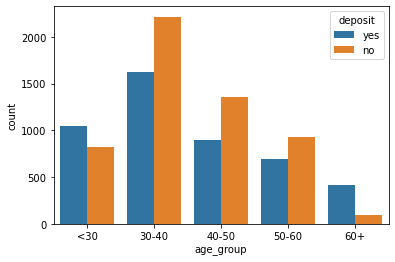

In [11]:
import seaborn as sns
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df)
#функция кат по заданному шаблону нарезает данные и делает порядковую переменную 

Также перекодируем образование (порядковый признак):

In [12]:
education_mapper = {"unknown":0, "primary":1, "secondary":2, "tertiary":3}
df["education_map"] = df["education"].replace(education_mapper) 
#маппер это словарь которому мы задаем что будет значением к ключу, работает это с реплейсом чтобы поменять категориальную переменную

## Время описательных статистик

Давайте узнаем, много ли человек в целом открыли депозиты?


no     5424
yes    4681
Name: deposit, dtype: int64


<AxesSubplot:xlabel='deposit', ylabel='count'>

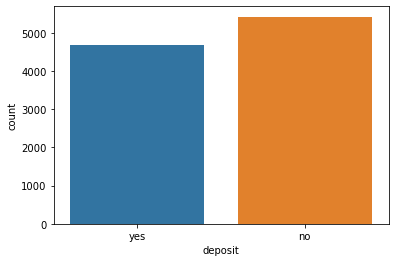

In [13]:
print(df["deposit"].value_counts())
sns.countplot(data = df,x = df['deposit'])

Теперь попробуйте сами с помощью известных вам функций ответить на следующие вопросы:

#### Каков максимальный возраст клиента банка?


In [14]:
df.age.max()

95

#### Какова минимальная длительность разговора с клиентом банка? 


In [13]:
df.duration.min()

2

#### В скольких месяцах была маркетинговая кампания?

In [14]:
#ваш код
df.month.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [15]:
len(df.month.unique())

12

#### Сколько всего профессий представлено среди клиентов банка?В какой профессии задействовано наибольшее количество клиентов банка?

In [15]:
df.describe(include = 'object')

job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          12        3          4       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2254     5715       5078    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424

**Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании в зависимости от предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.**


<AxesSubplot:xlabel='poutcome'>

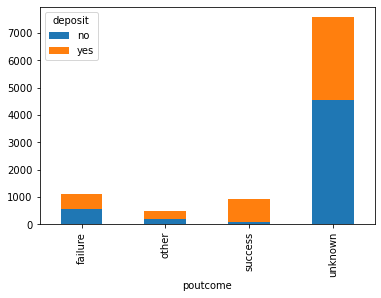

In [16]:
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True') #анстак сделал столбики здесь чтобы красиво было, без него столбики рядом будут

**Теперь давайте узнаем,  какова зависимость результата маркетинговых кампаний от месяца?Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов про использование определенных услуг. Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить.**

In [17]:
for i in np.unique(df.month):
    a = round(df[(df.month == i)&(df.deposit == 'no')].shape[0]/df[(df.month == i)].shape[0]*100,2)
    print(i, f'{a}%')

apr 38.19%
aug 55.96%
dec 9.68%
feb 45.56%
jan 60.82%
jul 58.96%
jun 54.89%
mar 10.13%
may 67.86%
nov 58.46%
oct 18.51%
sep 16.55%


## Тестирование гипотез

Давайте теперь проверим предложенные ниже гипотезы. Для каждой гипотезы необходимо сформулировать нулевую и альтернативную гипотезы, подобрать необходимый статистический критерий, провести расчеты и сделать выводы.

#### Отличается ли средняя длительность разговора у клиентов которые согласились открыть депозит и у клиентов, которые не согласились его открыть?

In [18]:
yes = df[df.deposit == 'yes']['duration'] #формируем выборки для текс кто согласился/нет на депозит
no = df[df.deposit == 'no']['duration']

In [19]:
from scipy import stats
ttest, pval = stats.ttest_ind(yes, no, alternative = 'two-sided')
print(ttest, pval) #нулевую гипотезу не принимаем

51.7599050298825 0.0


In [20]:
print(df[df.deposit == 'yes']['duration'].mean())
print(df[df.deposit == 'no']['duration'].mean())

539.568895535142
221.31674041297936


Изменится ли результат, если заменить альтернативу на одностороннюю?

#### Правда ли, что средний баланс отличается у тех, у кого есть кредит в просрочке и у тех, у кого нет кредита в просрочке?

In [21]:
yes = df[df.default == 'yes']['balance']
no = df[df.default == 'no']['balance']
ttest, pval = stats.ttest_ind(yes, no, alternative = 'two-sided')
print(ttest, pval) #нулевую гипотезу не принимаем

-11.219067944340582 4.8792674601876867e-29


#### Проверим гипотезу о том, что доля взявших депозит равна 0.5
АНДЕРСТЕНД ИТ БЕТТЕР

In [22]:
yes_d = len( df[df.deposit == 'yes']['duration'] )

In [23]:
yes_d/len(df)

0.4632360217714003

In [25]:
stats.binom_test(yes_d, len(df), 0.5, alternative = 'two-sided')

1.528995762689583e-13

#### Проверим гипотезу о том, что есть зависимость между уровнем образования и согласием/несогласием открыть депозит

In [26]:
t = df.groupby('education')['deposit'].value_counts().unstack()
t

deposit      no   yes
education            
primary     832   517
secondary  2839  2239
tertiary   1526  1713
unknown     227   212

In [27]:
stats.chi2_contingency(t, correction=False)

(101.67572341447327,
 6.778848915395374e-22,
 3,
 array([[ 724.09460663,  624.90539337],
        [2725.68748144, 2352.31251856],
        [1738.57852548, 1500.42147452],
        [ 235.63938644,  203.36061356]]))

#### Проверьте гипотезу о том, что есть взаимосвязь между возрастом (категорией) и просрочкой кредита

In [29]:
# проверьте гипотезу сами
t = df.groupby('age_group')['default'].value_counts().unstack()
t

default      no  yes
age_group           
<30        1836   34
30-40      3788   54
40-50      2203   52
50-60      1600   25
60+         512    1

In [30]:
stats.chi2_contingency(t, correction=False)

(14.598192285978705,
 0.005611430883334824,
 4,
 array([[1839.28055418,   30.71944582],
        [3778.88550223,   63.11449777],
        [2217.95596239,   37.04403761],
        [1598.30529441,   26.69470559],
        [ 504.57268679,    8.42731321]]))

#### Проверьте гипотезу, что есть разница в уровне образования между теми, кто открыл депозит и кто не открыл (используйте критерий Манна-Уитни)

In [32]:
x = df[df.deposit == 'yes']["education_map"]
y = df[df.deposit == 'no']["education_map"]
stats.mannwhitneyu(x, y, alternative = 'two-sided')

MannwhitneyuResult(statistic=13890147.5, pvalue=4.226293920155862e-19)

#### Придумайте еще гипотезы, которые можно проверить на ваших данных и проверьте их

In [ ]:
# место для вашей фантазии